In [2]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
  Using cached https://www.piwheels.org/simple/import-ipynb/import_ipynb-0.1.4-py3-none-any.whl (4.5 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
  Using cached https://www.piwheels.org/simple/scipy/scipy-1.14.0-cp311-cp311-linux_armv7l.whl (25.2 MB)

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


importing Jupyter notebook from calibracao.ipynb
O loop foi executado por 7 segundos taxa de amostragem 0.001.


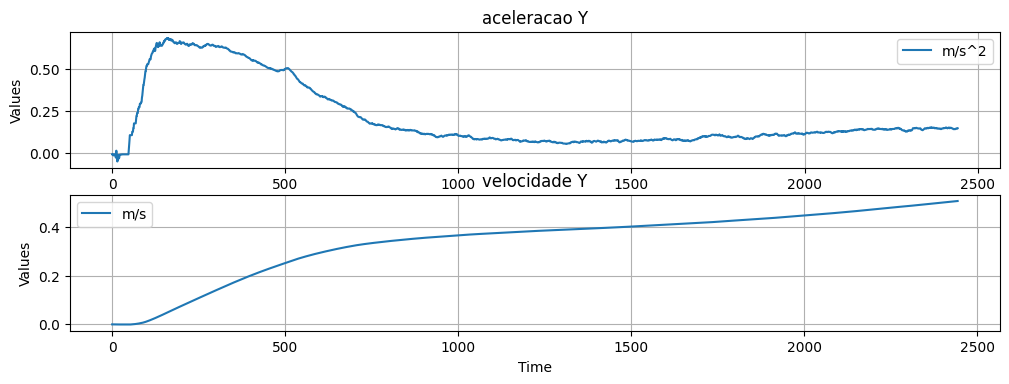

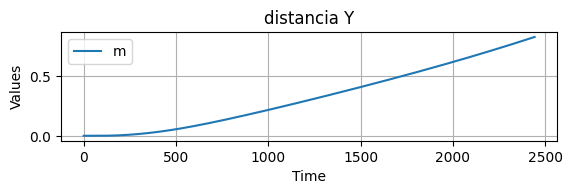

percorreu 807.1740026586261 metros


In [1]:

#FUNCIONA

import numpy as np
import bluerobotics_navigator as navigator
import time
import datetime
import matplotlib.pyplot as plt
import import_ipynb
import calibracao
from bluerobotics_navigator import PwmChannel
from scipy.integrate import simpson


# Definir pinos dos motores
PWM_PIN_M = navigator.PwmChannel.Ch4 # Pino PWM para o motor 
IN1_PIN_M = navigator.PwmChannel.Ch3  # Pino IN1 para o motor s
IN2_PIN_M = navigator.PwmChannel.Ch2  # Pino IN2 para o motor 

# Definir pino do servo motor
SERVO_PIN = navigator.PwmChannel.Ch1 # Pino para o servo motor

# Definir estado dos PWMs
navigator.set_pwm_freq_hz(60)
navigator.set_pwm_enable(True)

# Inicializar o Navigator
navigator.init() 



# Funções de controle dos motores
def motor_forward():
    navigator.set_pwm_channel_duty_cycle(IN1_PIN_M, 0)
    navigator.set_pwm_channel_duty_cycle(IN2_PIN_M, 1)
    navigator.set_pwm_channel_duty_cycle(PWM_PIN_M, 1)
    navigator.set_pwm_enable(True)

def motor_backward():
    navigator.set_pwm_channel_duty_cycle(IN1_PIN_M, 1)
    navigator.set_pwm_channel_duty_cycle(IN2_PIN_M, 0)
    navigator.set_pwm_channel_duty_cycle(PWM_PIN_M, 1)
    navigator.set_pwm_enable(True)

def stop_motor():
    navigator.set_pwm_enable(False)
    navigator.set_pwm_channel_duty_cycle(IN1_PIN_M, 0)
    navigator.set_pwm_channel_duty_cycle(IN2_PIN_M, 0)
    navigator.set_pwm_channel_duty_cycle(PWM_PIN_M, 0)

def direction_servo(direction=0.105):
    navigator.set_pwm_enable(True)
    if direction == 'direita':
        x = 0.15
    elif direction == 'esquerda':
        x = 0.105
    elif direction == 'reto':
        x = 0.13
        
    else:
        x = direction
    navigator.set_pwm_channel_duty_cycle(SERVO_PIN, x)




# Defina a duração do loop em segundos

frente = 2
re = 2
duracao = 7  # por exemplo, 5 segundos
Ts = 0.001

# Obtenha o tempo de início
tempo_inicial = time.time()
value_accel_x = []
value_accel_y = []
value_accel_z = []

value_giro_x = []
value_giro_y = []
value_giro_z = []
valor_filtro = []

velocita = [0]
posita = [0]
tempo = [0]

acceleration = navigator.read_accel()
accel_x = acceleration.x
accel_y = acceleration.y
accel_z = acceleration.z

angular_velocity = navigator.read_gyro()
giro_x = angular_velocity.x
giro_y = angular_velocity.y
giro_z = angular_velocity.z

acceleration = navigator.read_accel()
acy = acceleration.y
offsety = calibracao.calibra_y(1000)
x = 0.105
while time.time() - tempo_inicial < duracao:
    tempo.append(tempo[-1] + Ts)
    tempo_atual = time.time() - tempo_inicial
    if tempo_atual < duracao:
        direction_servo('reto')
        motor_forward() #-------------------------------------------------------

    #elif tempo_atual > frente and tempo_atual < duracao:
        #motor_backward()
    acceleration = navigator.read_accel()
    accel_x = acceleration.x
    accel_y = calibracao.add_value(valor_filtro, acceleration.y, 400, 1, 20000) - offsety
    accel_z = acceleration.z
    value_accel_y.append(accel_y)
    # Integração para obter a velocidade usando a regra de Simpson
    if len(value_accel_y) > 1:
        new_velocita = simpson(value_accel_y, dx=Ts)
    else:
        new_velocita = 0
    velocita.append(new_velocita)
    
    # Integração para obter a posição usando a regra de Simpson
    if len(velocita) > 1:
        new_posita = simpson(velocita, dx=Ts)
    else:
        new_posita = 0
    posita.append(new_posita)
    
    time.sleep(Ts)  # Adicione um atraso para simular uma operação dentro do loop
stop_motor()
#print(value_accel_y)
print(f"O loop foi executado por {duracao} segundos taxa de amostragem {Ts}.")

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)  # (linhas, colunas, índice do subplot)
plt.plot(range(len(value_accel_y)), value_accel_y, label='m/s^2')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('aceleracao Y')
plt.legend()
plt.grid(True)



#---------------------------

def integrate_acceleration_to_velocity(acceleration, time_step):
    velocity = [0]  # Começamos com velocidade inicial zero
    for i in range(1, len(acceleration)):
        # Usando a regra do trapézio para integração
        delta_v = 0.5 * (acceleration[i-1] + acceleration[i]) * time_step
        new_velocity = velocity[-1] + delta_v
        velocity.append(new_velocity)
    return velocity

# Exemplo de uso
acceleration = value_accel_y # Exemplo de valores de aceleração em m/s^2
time_step = Ts  # Exemplo de intervalo de tempo em segundos entre as amostras

velocity = integrate_acceleration_to_velocity(acceleration, time_step)

#print("Valores de velocidade calculados:", velocity)
plt.subplot(3, 1, 2)
plt.plot(range(len(velocita)), velocita, label='m/s')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('velocidade Y')
plt.legend()
plt.grid(True)
plt.show()

#--------------------

def integrate_velocity_to_distance(velocity, time_step):
    distance = [0]  # Começamos com distância inicial zero
    for i in range(1, len(velocity)):
        # Usando a regra do trapézio para integração
        delta_d = 0.5 * (velocity[i-1] + velocity[i]) * time_step
        new_distance = distance[-1] + delta_d
        distance.append(new_distance)
    return distance


def calculate_final_position(acceleration, time_step):
    velocity = integrate_acceleration_to_velocity(acceleration, time_step)
    distance = integrate_velocity_to_distance(velocity, time_step)
    final_position = sum(posita)
    return final_position

distance = integrate_acceleration_to_velocity(velocity, time_step)
#print("Valores de velocidade calculados:", distance)
t = np.arange(len(value_accel_y)) * Ts
plt.subplot(3, 1, 3)
plt.plot(range(len(posita)), posita, label='m')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('distancia Y')
plt.legend()
plt.grid(True)
plt.show()

print(f'percorreu {sum(posita)} metros')
plt.show()